In [79]:
import ugradio
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import astropy
import math as m
import glob
import os

# import mpl_toolkits.axes_grid1 as axgrid
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import scipy

%matplotlib inline
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

## Constants

In [80]:
### Interferometer constants ###
T_NOISE = 90 # [K]
LO, RF = 1270, 1420.4058 # [MHz]
FREQ_RES = 8192 

LT_LAT, LT_LON, LT_ALT = ugradio.leo.lat, ugradio.leo.lon, ugradio.leo.alt


### Physical constants ###
c = 3e5 # [km/s]


### Coordinate constants ###
l_min, l_max = 105, 160 # [degrees]
b_min, b_max = 15, 50 # [degrees]

δb = 2
δl = lambda b: 2/np.cos(m.radians(b)) # take in b in degrees

Δl = l_max - l_min
Δb = b_max - b_min


## Loading in Data

In [81]:
# CODE TO LOAD SPECTRA NUMPY FILES IN A DICT

data_dict = {} # dict where key is coordinate (l, b)) and value is [main, noise_on, noise_off, [ra, dec, jd]]
                # where main, noise_on, noise_off are all numpy arrays of the spectra
for filename in os.listdir(os.getcwd() + '/data/celestial_data_full/fits_files/npy_data_files'):
    if filename == ".ipynb_checkpoints" or filename == '.DS_Store':
        continue
    split_name = filename.split("_")

    if split_name[0] == 'off':
        fits_type = 2 # off
    elif split_name[0] == 'on':
        fits_type = 1 # on
    else:
        fits_type = 0 # main

    ## l, b, ra, dec, jd ##
    _, l, b, ra, dec, jd, _ = split_name
    l, b, ra, dec, jd = float(l), float(b), float(ra), float(dec), float(jd) # convert strings to floats

    curr_data = np.load('data/celestial_data_full/fits_files/npy_data_files/' + filename) # load the spectra from file
    curr_data = np.mean(curr_data, axis=1)[10:-10] # keep the average in the dict
    
    if not data_dict.get((l, b)):
        data_dict[(l, b)] = [[], [], [], ra, dec, jd]      
    data_dict[(l, b)][fits_type] = curr_data


### Getting rid of bad coordinates

In [82]:
bad_coords = np.load('data/bad_coords.npy')

print(len(data_dict))
pop_coords = []
for coord in data_dict.keys():
    for i in range(len(bad_coords)):
        if np.isclose(coord[0], bad_coords[i][0], rtol=1e-05) and np.isclose(coord[1], bad_coords[i][1], rtol=1e-05):
            pop_coords.append(coord)

for coord in pop_coords:
    data_dict.pop(coord)
print(len(data_dict))

pop_coords = []
for coord in data_dict.keys():
    if coord[1] >= 35:
        pop_coords.append(coord)
       

for coord in pop_coords:
    data_dict.pop(coord)
print(len(data_dict))

413
323
241


In [83]:
#len(os.listdir(os.getcwd() + '/data/celestial_data_full/fits_files/npy_data_files'))

### Get ls, bs, ras, decs, and jds for each coordinate pair

In [84]:
# RUN THIS CELL TO LOOP THROUGH ALL SPECTRA 
# SAVES ls, bs, ras, decs, jds (as lists), specs (MAIN SPECTRA), and Ts which are ordered in the same order

ls0 = []
bs0 = []
ras0, decs0, jds0 = [], [], []
specs0 = []
# Ts = []

for coord in data_dict.keys():
    l, b = coord
    main, noise_on, noise_off, ra, dec, jd = data_dict.get(coord)
    
    if len(main) == 0 or len(noise_on) == 0 or len(noise_off) == 0:
        print(coord)
        continue
#     temperature = T_0(main, noise_on, noise_off)
    
    ls0.append(l)
    bs0.append(b)
    specs0.append(main)
#     Ts.append(temperature)
    ras0.append(ra)
    decs0.append(dec)
    jds0.append(jd)

ls0 = np.array(ls0)
bs0 = np.array(bs0)

print('Length of each quantity array:', len(ls0), len(bs0), len(ras0), len(decs0), len(jds0), len(specs0))

Length of each quantity array: 241 241 241 241 241 241


### Separate main, on, and off data sets

In [85]:
### Collect main, on, and off data separately and turn into arrays ###

main_data0 = []
on_data0 = []
off_data0 = []
for i in range(len(ls0)):
    main = data_dict[(ls0[i], bs0[i])][0]
    on = data_dict[(ls0[i], bs0[i])][1]
    off = data_dict[(ls0[i], bs0[i])][2]
    main_data0.append(main), on_data0.append(on), off_data0.append(off)

main_data0 = np.array(main_data0)
on_data0 = np.array(on_data0)
off_data0 = np.array(off_data0)

In [86]:
main_data0.shape

(241, 8172)

## Utility Functions

In [87]:
def calc_avg_power_fft(data):
    fft = np.fft.fft(data)
    pow_data = np.abs(fft)**2
    avg_data = np.mean(pow_data, axis=1)
    return np.fft.fftshift(avg_data)

def calc_avg(data):
    return np.mean(data, axis=1)

def calc_median_power_fft(data):
    fft = np.fft.fft(data)
    pow_data = np.abs(fft)**2
    avg_data = np.median(pow_data, axis=1)
    return np.fft.fftshift(avg_data)

def calc_freq(samples, frequency):
    return np.fft.fftshift(np.fft.fftfreq(samples, d=1/frequency))

############################################################################################################################

def calc_gain(main, on, off):
    #input main_data, on_data, off_data
    
    """
    Iterates over all coordinate pairs to compute the gain at each point.
    
    Inputs: main, on, and off data sets.
    Output: A list of gains equal in lenght to the number of coordinate pairs.
    
    """    

    gains = []
    for i in range(len(main)):
        G = (T_NOISE/(np.sum(on[i]-off[i]))) * np.sum(off[i]) #calc Gain
        gains.append(G)
        
    return np.array(gains)



def calc_velocities(ras, decs, jds):
    #input ras, decs, and jds
    
    """
    Iterates over the ra and dec of each coordinate pair and returns the doppler velocity (corrected w.r.t the LSR).
    Returns a list of velocities [km/s] equal in length of the number of coordinate pairs.
    """
    
    freqs = np.linspace(144,156,FREQ_RES) 
    doppler_velocity = (((freqs+LO)-RF)/RF)*c #doppler velocities -- km/s 
    
    main_ras = np.array(ras)
    main_decs = np.array(decs)
    main_jds = np.array(jds)
    
    velocity_correction = ugradio.doppler.get_projected_velocity(ra=main_ras, 
                                                                 dec=main_decs,
                                                                 jd=main_jds,
                                                                 obs_lat=LT_LAT,
                                                                 obs_lon=LT_LON,
                                                                 obs_alt=LT_ALT)
    velocity_correction = velocity_correction.to(astropy.units.km/astropy.units.s).value # converts to km/s

    dopp_vels = []
    for i in range(len(velocity_correction)):
        dopp_vel_lb = doppler_velocity + velocity_correction[i]
        dopp_vels.append(dopp_vel_lb)
        
    return np.array(dopp_vels) 



def calc_peak_max(main, on, off, ras, decs, jds): 
    #input main_data, on_data, off_data, ras, decs, and jds

    """
    Performs the calibration to convert to temperature and then return the max temperature [K] at each coordinate
    as well as that coordinate's cooresponding velcity [km/s].
    
    Inputs: main, on, and off files
    Returns: two arrays, one of the max temperatures, and one of the velocities.
    """
    
    velocities = calc_velocities(ras, decs, jds)
    G = calc_gain(main, on, off)
    
    Ts = []
    vels = []
    for i in range(len(main)):
        fitting_indices = np.where((velocities[i] > -100) & (velocities[i] < 100)) # we zoom in to ignore the ripples
        median = np.median(main[i][fitting_indices]/off[i][fitting_indices]) 
    
        y_data_fit = (main[i]/off[i])*G[i] - G[i]*median
        y_data_fit = y_data_fit[fitting_indices]
        x_data_fit = velocities[i]
        x_data_fit = x_data_fit[fitting_indices]
    
        T = np.max(y_data_fit)
        vel = x_data_fit[np.argmax(y_data_fit)]
        Ts.append(T), vels.append(vel)
    
    return np.array(Ts), np.array(vels)



#  def calc_peak_gaussian(main, on, off):
#     #input main_data, on_data, off_data
#     """
#     A function to compute the Temperature [K] and Velocity [km/s] 
#     at the peak using a gaussian fit.
#     """
    
#     main_avg = np.mean(main, axis=1)
#     on_avg = np.mean(on, axis=1)
#     off_avg = np.mean(off, axis=1)
    
#     velocities = calc_velocities()
    
#     fitting_indices = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
#     G = calc_gain(main, on, off)
    
#     median = np.median(main_avg[fitting_indices]/off_avg[fitting_indices]) 
    
#     y_data_fit = (main_avg/off_avg)*G - G*median
#     y_data_fit = y_data_fit[fitting_indices]
#     x_data_fit = velocities
#     x_data_fit = x_data_fit[fitting_indices]
    

#     fit_params = ugradio.gauss.gaussfit(x_data_fit, 
#                                         y_data_fit, 
#                                         amp=np.max(y_data_fit),
#                                         avg=x_data_fit[np.argmax(y_data_fit)],
#                                         sig=10) #get Gaussian fit
    
    
#     T, vel = fit_params['amp'][0], fit_params['avg'][0]
                 
#     return T, vel

### Initial plot to distinguish further bad points

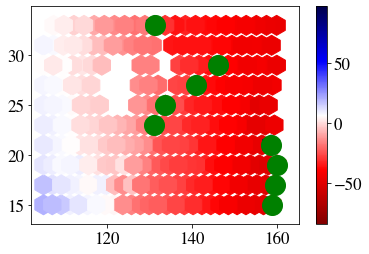

In [88]:
Vs = calc_peak_max(main_data0, on_data0, off_data0, ras0, decs0, jds0)[1]

indices = np.where(np.array(Vs) <= -50)
indices2= np.where(np.array(Vs) >= 50)
indices = np.append(indices, indices2)
indices
plt.figure()
plt.scatter(ls0, bs0, c=Vs, cmap='seismic_r', s=400, marker='h')
plt.colorbar()
plt.scatter(ls0[indices], bs0[indices], color='green', s=400)

#### Remove bad points from data_dict and recompute

In [89]:
for i in indices:
    coord = (tuple([ls0[i], bs0[i]]))
    data_dict.pop(coord)

In [90]:
ls = []
bs = []
ras, decs, jds = [], [], []
specs = []

for coord in data_dict.keys():
    l, b = coord
    main, noise_on, noise_off, ra, dec, jd = data_dict.get(coord)
    
    if len(main) == 0 or len(noise_on) == 0 or len(noise_off) == 0:
        print(coord)
        continue
    
    ls.append(l)
    bs.append(b)
    specs.append(main)
    ras.append(ra)
    decs.append(dec)
    jds.append(jd)

ls = np.array(ls)
bs = np.array(bs)

print('Length of each quantity array:', len(ls), len(bs), len(ras), len(decs), len(jds), len(specs))

Length of each quantity array: 232 232 232 232 232 232


In [91]:
main_data = []
on_data = []
off_data = []
for i in range(len(ls)):
    main = data_dict[(ls[i], bs[i])][0]
    on = data_dict[(ls[i], bs[i])][1]
    off = data_dict[(ls[i], bs[i])][2]
    main_data.append(main), on_data.append(on), off_data.append(off)

main_data = np.array(main_data)
on_data = np.array(on_data)
off_data = np.array(off_data)

In [92]:
main_data.shape

(232, 8172)

#### This is now the good data that we will plot and interpolate from

### Projection Map

In [118]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from matplotlib.patches import Rectangle


def plot_FOV(ax, color, label):
    
    FOV = (2 * (np.pi/180))/ 2
    n = 10
    xarr = np.arange(105, 160, 2)
    yarr = np.arange(15, 50, 2)
    for i in range(len(xarr)):
        for j in range(len(yarr)):
            x, y = xarr[i], yarr[j]
            gal = SkyCoord(x*u.degree, y*u.degree, frame='galactic')
            ra_dec = gal.transform_to('fk5')

            ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV), FOV*2 , FOV*2,
                         edgecolor = color,
                         facecolor = color,
                         alpha=0.65,
                         fill=True,
                         lw=3, label=label))
            
def plot_one_FOV_point(ax, color, label):
    
    FOV = (2 * (np.pi/180))/ 2
    n = 10
    xarr = np.array(105)
    yarr = np.array(15)
    x, y = xarr, yarr
    gal = SkyCoord(x*u.degree, y*u.degree, frame='galactic')
    ra_dec = gal.transform_to('fk5')

    ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV), FOV*2 , FOV*2,
                 edgecolor = color,
                 facecolor = color,
                 alpha=0.65,
                 fill=True,
                 lw=3, label=label))


def plot_observed_data(ax, color, label):
    
    FOV = (2 * (np.pi/180))/ 2
    for i in range(len(ls)):
        gal = SkyCoord(ls[i]*u.degree, bs[i]*u.degree, frame='galactic')
        ra_dec = gal.transform_to('fk5')

        ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV), FOV*2 , FOV*2,
                                 edgecolor = color,
                                 facecolor = color,
                                 alpha=0.75,
                                 fill=True,
                                 lw=3, label=label))
        
def plot_one_obs_point(ax, color, label):
    FOV = (2 * (np.pi/180))/ 2
    gal = SkyCoord(ls[0]*u.degree, bs[0]*u.degree, frame='galactic')
    ra_dec = gal.transform_to('fk5')

    ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV), FOV*2 , FOV*2,
                             edgecolor = color,
                             facecolor = color,
                             alpha=0.75,
                             fill=True,
                             lw=3, label=label))

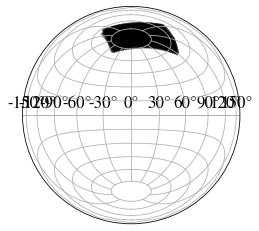

In [94]:
plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1, projection='lambert')
ax.grid(True)
plot_FOV(ax, color="black", label="Target")

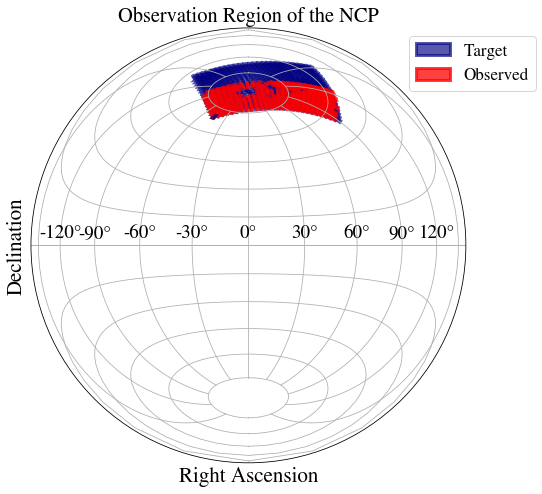

In [131]:
f = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection="lambert")
ax.grid(True)

plot_FOV(ax, color='navy', label=None)
plot_observed_data(ax, color='red', label=None)
plot_one_FOV_point(ax, 'navy', 'Target')
plot_one_obs_point(ax, 'red', 'Observed')

dg = u"\N{DEGREE SIGN}"
ax.set_xticklabels(labels=["","-120"+dg, "-90"+dg,"-60"+dg, "-30"+dg,"0"+dg, "30"+dg, "60"+dg, "90"+dg, "120"+dg, ""],
                   fontdict={'fontsize':19})
ax.legend(bbox_to_anchor=(0.85, 1), loc='upper left')
ax.set_xlabel('Right Ascension', fontsize=21)
ax.set_ylabel('Declination', fontsize=21)
ax.set_title('Observation Region of the NCP')
plt.show()



# Plotting and interpolating

### Initial temperature and velocity maps

Temperature extrema: 6.714654491882669 138.1628254507296
Velocity extrema: 20.34822146381882 -49.90269600764312


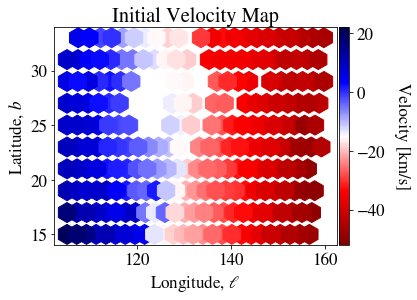

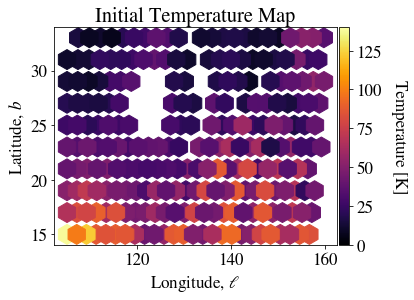

In [137]:
Ts, vs = calc_peak_max(main_data, on_data, off_data, ras, decs, jds)

T_max, T_min = np.max(Ts), np.min(Ts)
v_max, v_min = np.max(vs), np.min(vs)

print('Temperature extrema:', T_min, T_max)
print('Velocity extrema:', v_max, v_min)


plt.figure()
plt.title('Initial Velocity Map')
plt.scatter(ls, bs, c=vs, cmap='seismic_r', s=400, marker='h', vmin=-52, vmax=22)
cbar = plt.colorbar(pad=0.005)
cbar.set_label('Velocity [km/s]', rotation=270, labelpad=25)
plt.xlabel('Longitude, $\ell$')
plt.ylabel('Latitude, $b$')
plt.show()

plt.figure()
plt.title('Initial Temperature Map')
plt.scatter(ls, bs, c=Ts, cmap='inferno', s=400, marker='h', vmin=0, vmax=140)
cbar = plt.colorbar(pad=0.005)
cbar.set_label('Temperature [K]', rotation=270, labelpad=25)
plt.xlabel('Longitude, $\ell$')
plt.ylabel('Latitude, $b$')
plt.show()

### Interpolation

In [138]:
coords = np.array([ls,bs]).T

In [139]:
from scipy.interpolate import griddata
grid_x, grid_y = np.meshgrid(np.linspace(105,160,500),
                             np.linspace(15, 50, 500))

xmin, xmax = 135, 160
ymin, ymax = 15, 35

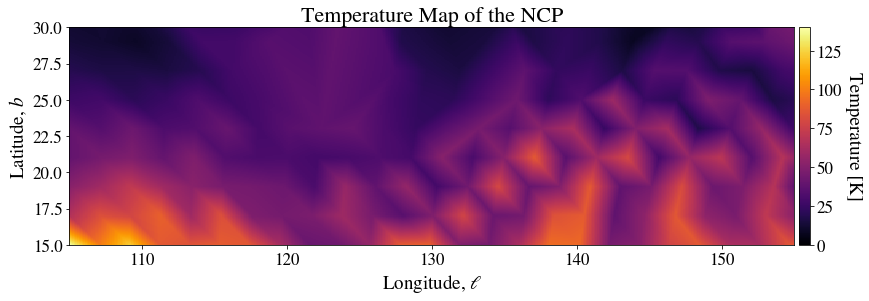

In [144]:
grid_temps = griddata(coords, Ts, (grid_x, grid_y), method='linear')

plt.figure(figsize=(16,4))
im = plt.imshow(grid_temps, extent=[105, 160, 15, 50], origin='lower', aspect='equal', cmap='inferno', vmin=0, vmax=140)
plt.ylim(15, 30)
plt.xlim(105, 155)
cbar = plt.colorbar(im, pad=0.005)
cbar.set_label('Temperature [K]', rotation=270, labelpad=20, fontsize=19)
plt.xlabel('Longitude, $\ell$', fontsize=19)
plt.ylabel('Latitude, $b$', fontsize=19)
plt.title('Temperature Map of the NCP', fontsize=22)
plt.show()

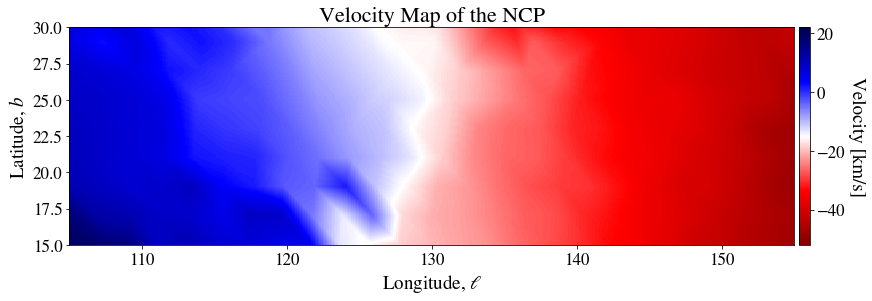

In [146]:
grid_vels = griddata(coords, vs, (grid_x, grid_y), method='linear')

plt.figure(figsize=(16,4))
im = plt.imshow(grid_vels, extent=[105, 160, 15, 50], origin='lower', aspect='equal', cmap='seismic_r', vmin=-52, vmax=22)
plt.ylim(15, 30)
plt.xlim(105, 155)
cbar = plt.colorbar(im, pad=.005)
cbar.set_label('Velocity [km/s]', rotation=270, labelpad=20, fontsize=19)
plt.xlabel('Longitude, $\ell$', fontsize=19)
plt.ylabel('Latitude, $b$', fontsize=19)
plt.title('Velocity Map of the NCP', fontsize=22)
plt.show()